In [102]:
import nibabel as nb
import nilearn
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import json
import glob
import pandas as pd
import plotly.express as px
import cortex
import sys
import os
import importlib

# nilearn import
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import fdr_threshold
from nilearn.plotting import plot_design_matrix 
from nilearn.glm.first_level import make_first_level_design_matrix,run_glm
from nilearn.glm.contrasts import compute_contrast
import scipy.stats as stats


import warnings
warnings.filterwarnings("ignore")



sys.path.append("{}/../../utils".format(os.getcwd()))
from pycortex_utils import draw_cortex, set_pycortex_config_file
from surface_utils import make_surface_image , load_surface

In [103]:
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'
subject = 'sub-02'
group = '327'

task = 'PurLoc'

high_pass_type = 'dct'
session = 'ses-02'
runs = ['01','02']
hemis = ['L','R']



In [104]:
# load settings
with open('/Users/uriel/disks/meso_H/projects/RetinoMaps/analysis_code/settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
TR = analysis_info['TR']
TRs = analysis_info['TRs']
glm_alpha = analysis_info['glm_alpha']

# Load events

In [105]:
event_dir = '{}/{}/{}/{}/func/'.format(main_dir,project_dir,subject,session)

In [106]:
event_file = glob.glob("{}/{}_{}_task-{}_run-*_events.tsv".format(event_dir,subject,session,task))

In [107]:
events_run_1 = pd.read_table(event_file[0])
events_run_2 = pd.read_table(event_file[1])

# Load avg data

In [108]:
avg_dir = '{}/{}/derivatives/pp_data/{}/fsnative/func/fmriprep_dct_avg'.format(main_dir,project_dir,subject)
avg_L_fn = '{}_task-{}_hemi-L_fmriprep_dct_avg_bold.func.gii'.format(subject,task)
avg_R_fn = '{}_task-{}_hemi-R_fmriprep_dct_avg_bold.func.gii'.format(subject,task)

In [109]:
img_avg_bold_L, data_avg_bold_L = load_surface(fn='{}/{}'.format(avg_dir,avg_L_fn))
img_avg_bold_R, data_avg_bold_R = load_surface(fn='{}/{}'.format(avg_dir,avg_R_fn))

# GLM

## Designe matrix 

In [110]:
tr = TR  # repetition time is 1 second
n_scans = TRs  # the acquisition comprises 128 scans
frame_times = np.arange(n_scans) * tr  # here are the corresponding frame times

In [111]:
events = pd.read_table(event_file[0])
events_glm = events[['onset','duration','trial_type']].copy(deep=True)
events_glm.replace({'trial_type': {3: 'Fix', 1: 'Sac', 2: 'Pur'}},inplace=True)
events_glm.duration = TR
events_glm.onset = 0
events_glm_groups = events_glm.groupby((events_glm.trial_type!=events_glm.trial_type.shift()).cumsum())

new_events_glm = pd.DataFrame([], columns=['onset', 'duration', 'trial_type'])
for idx, group in enumerate(events_glm_groups):
    onset = group[1]['onset'][group[1].index[0]]
    dur = sum(group[1]['duration'])
    ttype = group[1]['trial_type'][group[1].index[0]]

    new_events_glm = new_events_glm.append(pd.Series([onset,dur,ttype],index =['onset', 'duration', 'trial_type']), ignore_index=True)



In [112]:
for idx in new_events_glm.index:
    if idx == 0:
        new_events_glm.at[idx, 'onset'] = 0
    else:
        new_events_glm.at[idx, 'onset'] = new_events_glm.at[idx - 1, 'onset'] + new_events_glm.at[idx - 1, 'duration']


In [113]:
design_matrix = make_first_level_design_matrix(frame_times,
                                               events=new_events_glm,
                                               hrf_model='spm',
                                               drift_model=None
                                               )

In [114]:
design_matrix.shape

(208, 3)

In [15]:
#plot_design_matrix(design_matrix)

## Model

### Model ar1

In [60]:
noise_model_2 ="ar1"

In [73]:
# fit model
labels_L_2, estimates_L_2 = run_glm(data_avg_bold_L, design_matrix.values,noise_model=noise_model_2)
labels_R_2, estimates_R_2 = run_glm(data_avg_bold_R, design_matrix.values,noise_model=noise_model_2)

In [86]:
# acces to prediction and r2  for ar model 
def extract_predictions_r2 (labels,estimate,source_data):
    cl_names = np.unique(labels)

    n_cl = cl_names.size
    list_cl = []

    idx_in_cl = np.zeros_like(labels, dtype=int)

    for i in range(n_cl):
        list_idx = np.argwhere(labels==cl_names[i]).flatten()
        list_cl += [list_idx]
        for i_cnt, idx in enumerate(list_idx):
            idx_in_cl[idx] = i_cnt

    # acces to predictions and r2 for left hemisphere 
    predictions = np.zeros(source_data.shape, dtype=float)
    rsquare = np.zeros_like(labels, dtype=float)
    N = rsquare.size
    for idx,labels_ in enumerate(labels) :    
        label_mask = labels[idx]
        predictions[:,idx] = estimate[label_mask].predicted[:,idx_in_cl[idx]]
        rsquare[idx] = estimate[label_mask].r_square[idx_in_cl[idx]]
        
    return predictions, rsquare


In [87]:
pred_L_2, rsquare_L_2 = extract_predictions_r2 (labels = labels_L_2 ,estimate = estimates_L_2 ,source_data = data_avg_bold_L )


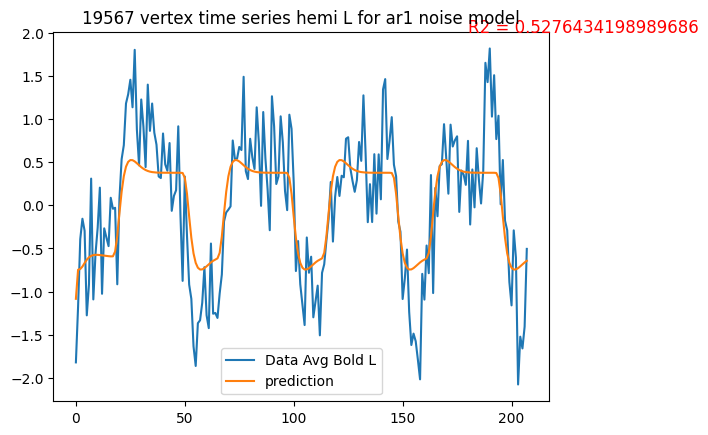

In [88]:
# plot best voxel for left hemisphere
max_indices = np.argmax(rsquare_L_2)
vert = max_indices
plt.plot(data_avg_bold_L[:, vert], label='Data Avg Bold L')
plt.plot(pred_L_2[:, vert], label='prediction')

# Ajouter du texte à des positions spécifiques
plt.text(180, 2, 'R2 = {}'.format(rsquare_L_2[vert]), fontsize=12, color='red')
plt.title('{} vertex time series hemi L for {} noise model'.format(vert,noise_model_2))

plt.legend()  # Ajouter la légende si nécessaire
plt.show()

best r2 is 0.5276434198989686


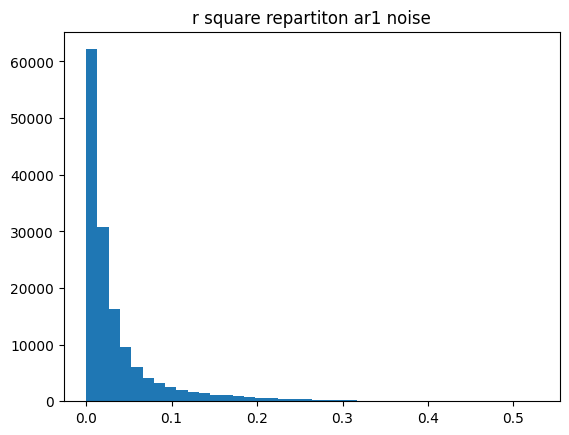

In [76]:
plt.hist(rsquare_L_2, bins=40)
plt.title('r square repartiton {} noise'.format(noise_model_2))
print('best r2 is',rsquare_L_2.max())

### Model OLS

In [115]:
noise_model = "ols"

In [116]:
# fit model with ols noise model 
labels_L, estimates_L = run_glm(data_avg_bold_L, design_matrix.values,noise_model=noise_model)
labels_R, estimates_R = run_glm(data_avg_bold_R, design_matrix.values,noise_model=noise_model)

In [58]:
for t in 
np.unique(labels_L)

array([0.])

In [39]:
data_to_analyse_pred = np.zeros(data_to_analyse.T.shape)
data_to_analyse_rsquare = np.zeros_like(labels)
for lab in np.unique(labels):
    data_to_analyse_pred[..., labels == lab] = getattr(estimates[lab], 'predicted')
    data_to_analyse_rsquare[..., labels == lab] = getattr(estimates[lab], 'r_square')

In [49]:
# acces to predictions and r2 for left hemisphere 
pred_L = np.zeros(data_avg_bold_L.shape)
rsquare_L = np.zeros_like(labels_L)
for label_ in estimates_L:
    label_mask = labels_L == label_


In [55]:
label_

0.0

In [56]:
label_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [57]:
labels_L

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
# acces to predictions and r2 for left hemisphere 
pred_L = np.zeros(data_avg_bold_L.shape)
rsquare_L = np.zeros_like(labels_L)
for label_ in estimates_L:
    label_mask = labels_L == label_
    reg = estimates_L[label_]
    pred_L[:,label_mask] = reg.predicted
    rsquare_L[label_mask] = reg.r_square

# acces to predictions and r2 for right hemisphere 
pred_R = np.zeros(data_avg_bold_R.shape)
rsquare_R = np.zeros_like(labels_R)
for label_ in estimates_R:
    label_mask = labels_R == label_
    reg = estimates_R[label_]
    pred_R[:,label_mask] = reg.predicted
    rsquare_R[label_mask] = reg.r_square

In [91]:
pred_L, rsquare_L = extract_predictions_r2 (labels = labels_L ,estimate = estimates_L ,source_data = data_avg_bold_L )


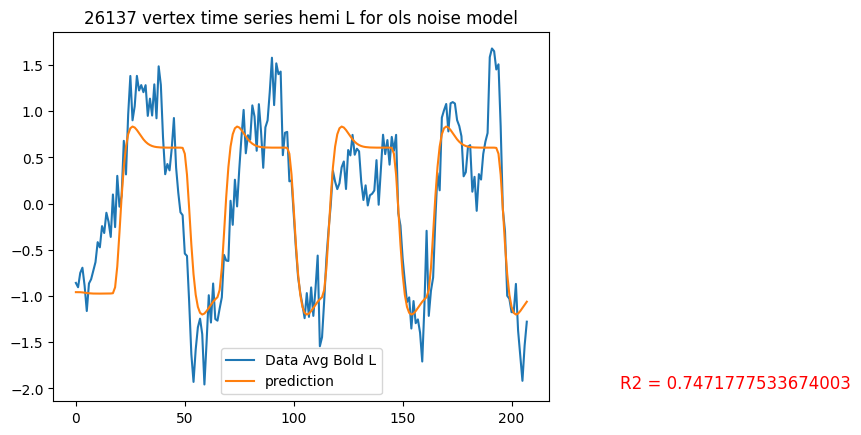

In [92]:
# plot best voxel for left hemisphere
max_indices = np.argmax(rsquare_L)
vert = max_indices
plt.plot(data_avg_bold_L[:, vert], label='Data Avg Bold L')
plt.plot(pred_L[:, vert], label='prediction')


plt.text(250, -2, 'R2 = {}'.format(rsquare_L[vert]), fontsize=12, color='red')
plt.title('{} vertex time series hemi L for {} noise model'.format(vert,noise_model))

plt.legend() 
plt.show()

best r2 is 0.7471777533674003


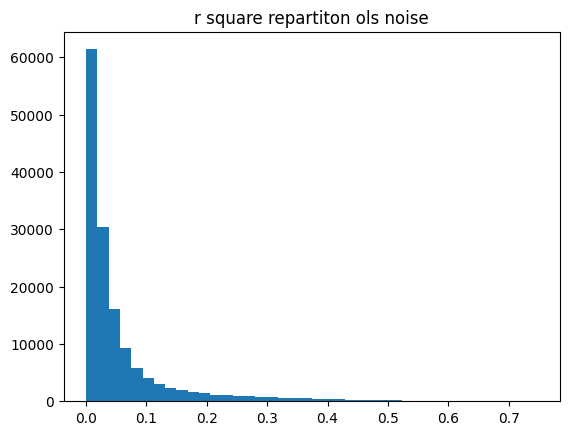

In [119]:
plt.hist(rsquare_L, bins=40)
plt.title('r square repartiton {} noise'.format(noise_model))
print('best r2 is',rsquare_L.max())

## Contrast

In [93]:
contrast_matrix = np.eye(design_matrix.shape[1])

In [94]:
basic_contrasts = dict([(column, contrast_matrix[i])for i, column in enumerate(design_matrix.columns)])

In [95]:
basic_contrasts

{'Fix': array([1., 0., 0.]),
 'Pur': array([0., 1., 0.]),
 'constant': array([0., 0., 1.])}

In [43]:
# # SacLoc
# contrasts = {
#     'Saccade - Fixation': (
#         basic_contrasts['Sac']
#         - basic_contrasts['Fix'])

    
# }

In [96]:
# PurLoc
contrasts = {'Saccade - Fixation': (basic_contrasts['Pur']- basic_contrasts['Fix'])}

In [98]:
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):

 
    # compute contrast-related statistics
    contrast_L = compute_contrast(labels_L, estimates_L, contrast_val,contrast_type='t')
    contrast_R = compute_contrast(labels_R, estimates_R, contrast_val,contrast_type='t')
                            
    # compute z-score 
    z_score_L = contrast_L.z_score()
    z_score_R = contrast_R.z_score()
    
    # compute p-value associated 
    # p_value_L = contrast_L.p_value()
    # p_value_R = contrast_R.p_value()

    p_value_L = contrast_L.one_minus_pvalue()
    p_value_R = contrast_R.one_minus_pvalue()

In [99]:
# concatenate the z_score to have all brain 
z_brain = np.concatenate((z_score_L,z_score_R))
p_brain = np.concatenate((p_value_L,p_value_R))

In [26]:
# Compute the threshold for z-score
thr = fdr_threshold(z_score_L,alpha=0.01)

# Plot with pycortex

In [100]:
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)
importlib.reload(cortex)

<module 'cortex' from '/Users/uriel/softwares/anaconda3/envs/amblyo_env/lib/python3.9/site-packages/cortex/__init__.py'>

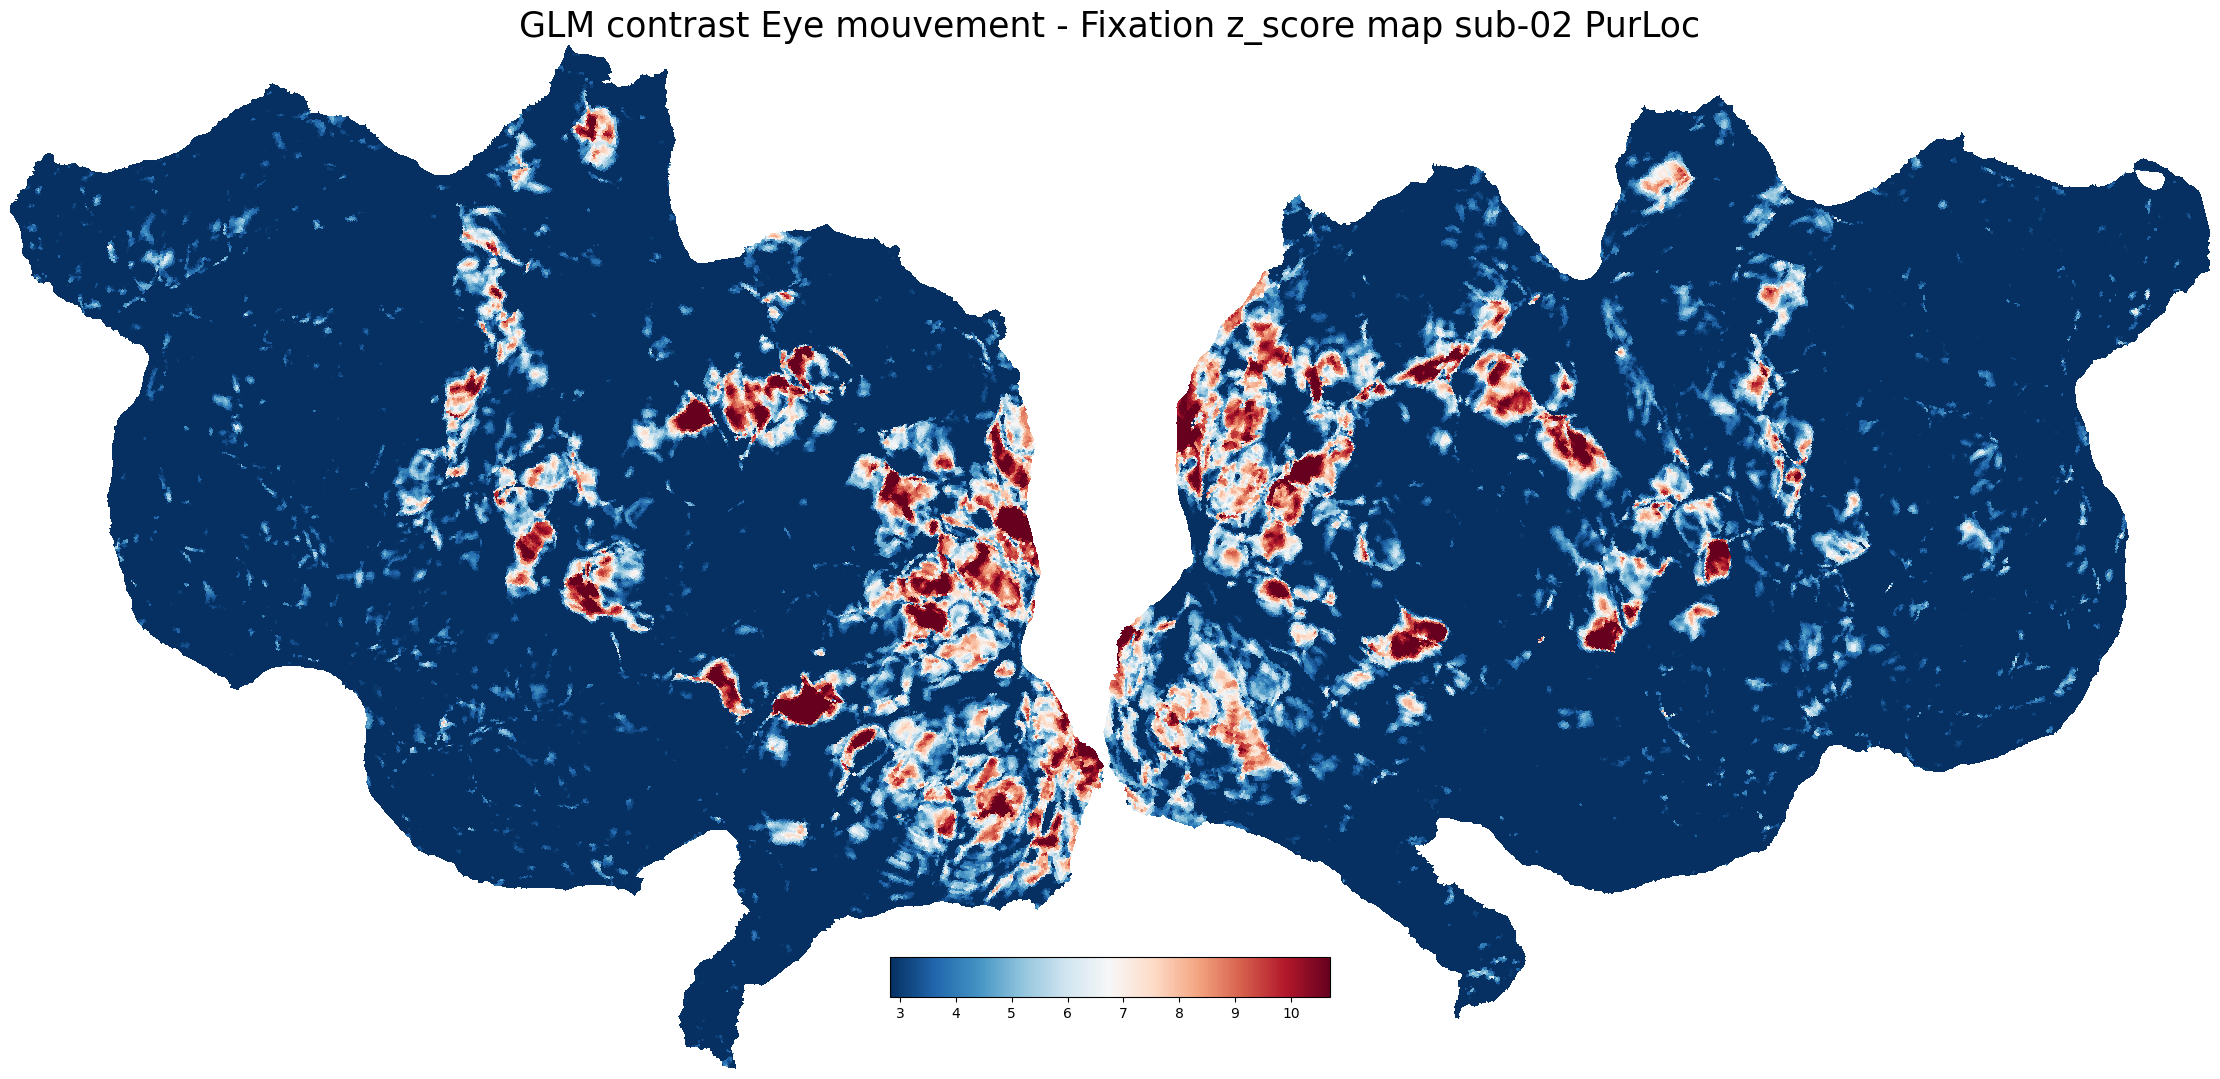

In [27]:
# creat the z-score flatmap with the threshold
vertex_data = cortex.Vertex(z_brain, subject,vmin=thr )

cortex.quickshow(vertex_data)
plt.title("GLM contrast Eye mouvement - Fixation z_score map {} {}".format(subject,task),fontsize=25)
plt.show()

RuntimeError: Inkscape doesn't seem to be installed on this system.SVGOverlay.get_texture requires inkscape.Please make sure that inkscape is installed and that is accessible from the terminal.

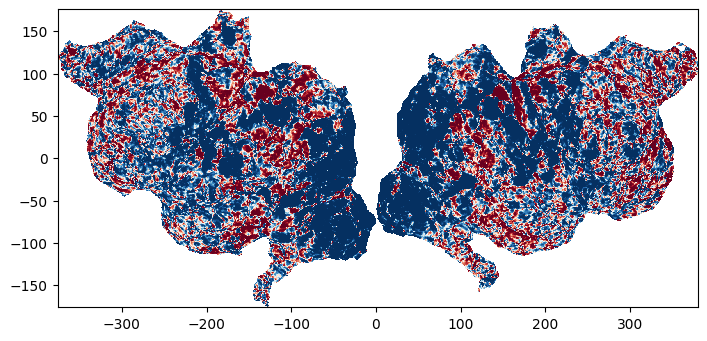

In [101]:
# creat the p-value flatmap with the threshold
vertex_data = cortex.Vertex(p_brain, subject,cmap='RdBu')

cortex.quickshow(vertex_data)
plt.title("GLM contrast Eye mouvement - Fixation p-value map {} {}".format(subject,task),fontsize=25)
plt.show()

# Brouillon 

In [ ]:
meta_L = img_avg_bold_L.meta
header_L = img_avg_bold_L.header

meta_R = img_avg_bold_R.meta
header_R = img_avg_bold_R.header


GLM_final_L = z_score_L.astype(np.float32) 
GLM_img_L = nb.gifti.GiftiImage(header=header_L, meta=meta_L)
GLM_darray_L = nb.gifti.GiftiDataArray(data=GLM_final_L.flatten())
GLM_img_L.add_gifti_data_array(GLM_darray_L)

GLM_final_R = z_score_R.astype(np.float32) 
GLM_img_R = nb.gifti.GiftiImage(header=header_R, meta=meta_R)
GLM_darray_R = nb.gifti.GiftiDataArray(data=GLM_final_R.flatten())
GLM_img_R.add_gifti_data_array(GLM_darray_R)
        

#Export preproceced data
out_flt_file_L = "/Users/uriel/Desktop/glm_L_{}.func.gii".format(task)
out_flt_file_R = "/Users/uriel/Desktop/glm_R_{}.func.gii".format(task)

nb.save(GLM_img_L, out_flt_file_L)
nb.save(GLM_img_R, out_flt_file_R)

In [70]:
glm_scale = [np.min(z_brain),np.max(z_brain)]
cmap_GLM = 'hot'
# alpha_range = [0,1]
# alpha = (p_brain - alpha_range[0])/(alpha_range[1]-alpha_range[0])
# alpha[alpha>1]=1
# alpha = alpha.astype(np.uint8)

alpha = p_brain



param_glm = {'subject':subject,'xfmname' : None,'data': z_brain, 'cmap': cmap_GLM ,'alpha' : alpha,
              'vmin':  thr, 'vmax': glm_scale[1], 'cbar': 'discrete', 
              'cortex_type': 'VertexRGB', 'description': "GLM contrast Eye mouvement - Fixation z_score map {} {}".format(subject,task), 
              'curv_brightness': 1, 'curv_contrast': 0.1, 'add_roi': False, 'cbar_label': 'Z-score',
              'with_labels': True}


<RGB vertex data for (sub-02)>

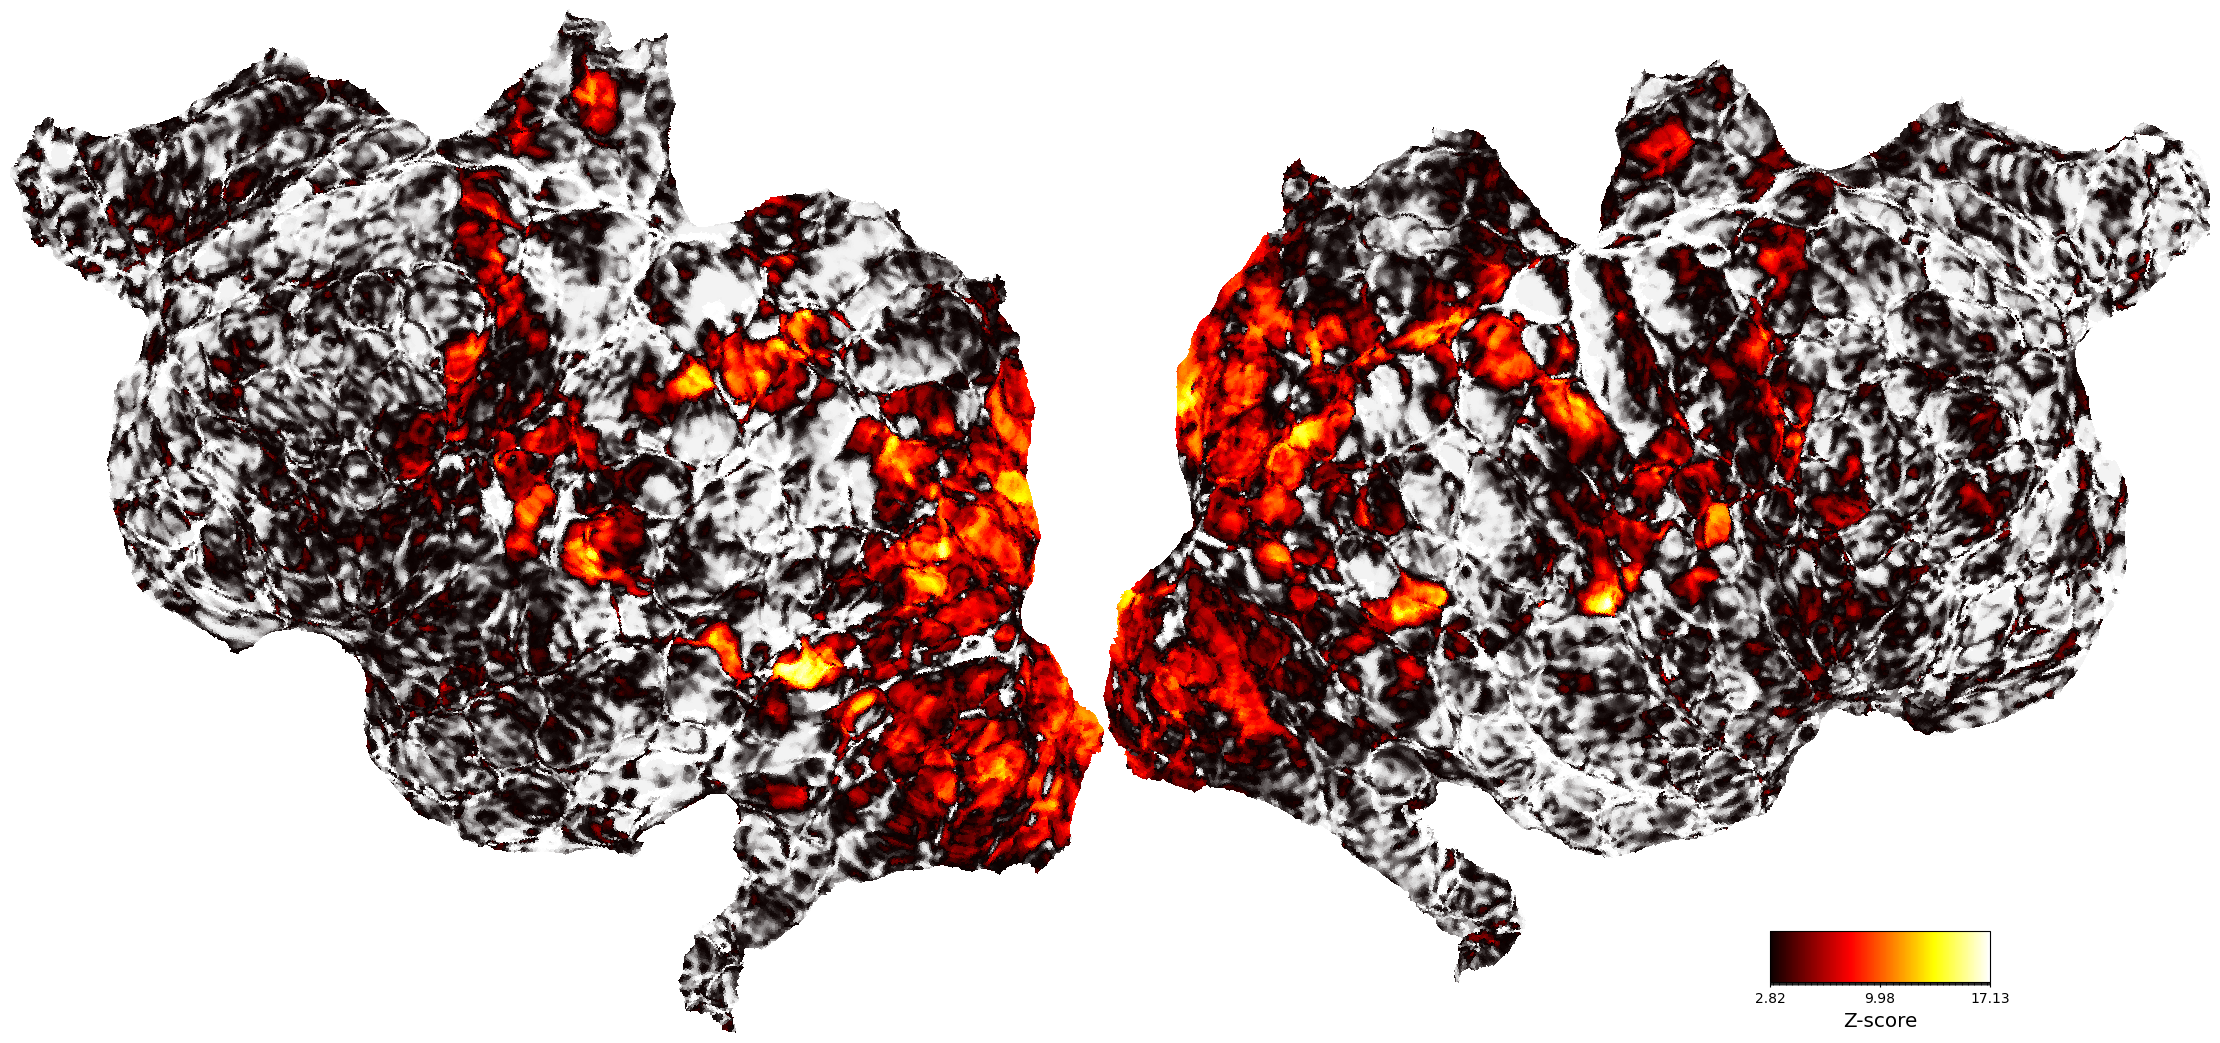

In [71]:
draw_cortex(**param_glm)

In [112]:
out_fit_name = '/Users/uriel/Desktop/fit_test.func.gii'

img_avg_bold_hemi_header= img_avg_bold_L.header
img_avg_bold_hemi_meta= img_avg_bold_L.meta
fit_img_hemi = nb.gifti.GiftiImage(header=img_avg_bold_hemi_header, meta=img_avg_bold_hemi_meta)

for i in range(fit.shape[1]):
    data = fit[:,i]
    darray = nb.gifti.GiftiDataArray(data,datatype = 'NIFTI_TYPE_FLOAT32')
    fit_img_hemi.add_gifti_data_array(darray)
nb.save(fit_img_hemi, out_fit_name)
print('export fit done')

export fit done


In [110]:
for data in fit[1]:
    a = data

In [116]:
z_map.shape

(147618,)

In [121]:
img2 = nb.load('/Users/uriel/Desktop/fit_test.func.gii')

In [122]:
img_data2 = [x.data for x in img2.darrays]
cur_data2 = np.vstack(img_data2)  

In [125]:
cur_data2 == fit

False

In [126]:
cur_data2.shape

(5, 147618)

In [127]:
fit.shape

(147618, 5)

In [128]:
data_avg_bold_hemi.shape

NameError: name 'data_avg_bold_hemi' is not defined

In [132]:
for contrast_num, contrast in enumerate(zip(cond1_label,cond2_label)):
    print(contrast_num)

    contrast_values = (design_matrix.columns == contrast[0]) * 1.0 -(design_matrix.columns == contrast[1])
    eff = compute_contrast(labels_L, estimates_L, contrast_values,contrast_type='t')


    z_map = eff.z_score()
    z_p_map = 2*(1 - stats.norm.cdf(abs(z_map)))
    fdr_th = fdr_threshold(z_map, glm_alpha)
    fdr = z_map
    fdr *= (z_map > fdr_th)
    fdr_p_map = 2*(1 - stats.norm.cdf(abs(fdr)))



    if contrast_num:
        fit = np.vstack((fit,z_map,z_p_map,fdr,fdr_p_map))
    else:                 
        fit = np.vstack((z_map,z_p_map,fdr,fdr_p_map,rsquare_L))

0


In [133]:
fit.shape

(5, 147618)

In [135]:
out_fit_name ='/Users/uriel/Desktop/test_nale.func.gii'
fit_img_hemi = nb.gifti.GiftiImage(header=img_avg_bold_hemi_header, meta=img_avg_bold_hemi_meta)

for i in range(fit.shape[0]):
    data = fit[i,:]
    darray = nb.gifti.GiftiDataArray(data,datatype = 'NIFTI_TYPE_FLOAT32')
    fit_img_hemi.add_gifti_data_array(darray)
nb.save(fit_img_hemi, out_fit_name)
print('export fit done')

export fit done


In [31]:
img_avg_bold_L = nb.load('/Users/uriel/Desktop/fdp.func.gii')
data_avg_bold_L = [x.data for x in img_avg_bold_L.darrays]
data_avg_bold_L = np.vstack(data_avg_bold_L) 

In [11]:
test_img = nb.load('/Users/uriel/Desktop/sub-02_task-pMF_hemi-L_fmriprep_dct_avg_bold.func.gii')

In [22]:
meta_map_dic = {'map_name':'z-map'}
meta_map = nb.gifti.gifti.GiftiMetaData(meta_map_dic)

In [35]:
img_avg_bold_L.darrays[0].meta = meta_map
img_avg_bold_L.darrays[1].meta = meta_map
img_avg_bold_L.darrays[2].meta = meta_map
img_avg_bold_L.darrays[3].meta = meta_map
img_avg_bold_L.darrays[4].meta = meta_map

In [37]:
img_avg_bold_L.darrays[0].meta

<GiftiMetaData {'map_name': 'z-map'}>

In [39]:
out_fit_name ='/Users/uriel/Desktop/proute.func.gii'
nb.save(img_avg_bold_L, out_fit_name)

In [41]:
os.system('wb_command -set-map-names /Users/uriel/Desktop/proute.func.gii -map 2 t-map')

0